# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

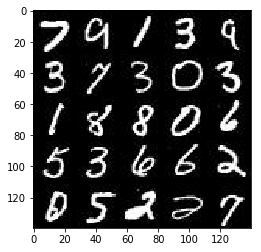

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

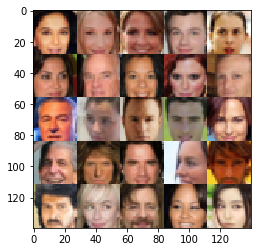

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels),name ="real_input") 
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim),name ="z_input") 
    learning_rate = tf.placeholder(tf.float32, name ="learning_rate") 

    return real_input,z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):        
        
        alpha = 0.2
        # First fully connected layer
        h1 = tf.layers.conv2d(images, 64, 4, 2, 'same', use_bias=False, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha*h1,h1)
        
        h2 = tf.layers.conv2d(h1, 128, 4, 2, 'same', use_bias=False, activation=None)
        #batch norm
        h2 = tf.layers.batch_normalization(h2, training=True)
        # Leaky ReLU
        h2 = tf.maximum(alpha*h2,h2)
        
        h3 = tf.layers.conv2d(h1, 256, 4, 2, 'same', use_bias=False, activation=None)
        #batch norm
        h3 = tf.layers.batch_normalization(h3, training=True)
        # Leaky ReLU
        h3 = tf.maximum(alpha*h3,h3)
        
        # Flatten it
        flat = tf.reshape(h3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        # First fully connected layer
        h1 = tf.layers.dense(z,7*7*512, activation = None)
        #batch norm
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        # Leaky ReLU
        h1 = tf.maximum(alpha*h1,h1)
        
        h2 = tf.layers.conv2d_transpose(h1, 200, 4, 2, 'same', use_bias=False, activation=None)
        #batch norm
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        # Leaky ReLU
        h2 = tf.maximum(alpha*h2,h2)
        
        h3 = tf.layers.conv2d_transpose(h2, 3, 4, 2, 'same', use_bias=False, activation=None)
        #batch norm
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        # Leaky ReLU
        h3 = tf.maximum(alpha*h3,h3)
        
        # Logits and tanh output
        logits = tf.layers.dense(h3,out_channel_dim, activation = None)
        
        output = tf.tanh(logits)
        
        return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.2
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_op, g_train_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    tf.reset_default_graph()

    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % 10 == 0:
                    # Print after 100
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 15, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1616... Generator Loss: 3.8286
Epoch 1/2... Discriminator Loss: 0.1815... Generator Loss: 3.0892
Epoch 1/2... Discriminator Loss: 0.8415... Generator Loss: 1.9350
Epoch 1/2... Discriminator Loss: 0.3384... Generator Loss: 1.7148
Epoch 1/2... Discriminator Loss: 0.9559... Generator Loss: 0.9193
Epoch 1/2... Discriminator Loss: 0.7461... Generator Loss: 1.0667
Epoch 1/2... Discriminator Loss: 0.9549... Generator Loss: 1.9354
Epoch 1/2... Discriminator Loss: 0.6394... Generator Loss: 1.2107
Epoch 1/2... Discriminator Loss: 0.8207... Generator Loss: 1.6315
Epoch 1/2... Discriminator Loss: 0.8154... Generator Loss: 0.8181


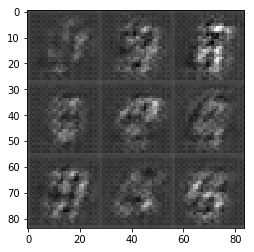

Epoch 1/2... Discriminator Loss: 0.7973... Generator Loss: 1.6244
Epoch 1/2... Discriminator Loss: 0.7112... Generator Loss: 2.3639
Epoch 1/2... Discriminator Loss: 0.9813... Generator Loss: 2.6255
Epoch 1/2... Discriminator Loss: 1.3064... Generator Loss: 3.0366
Epoch 1/2... Discriminator Loss: 0.9813... Generator Loss: 0.6159
Epoch 1/2... Discriminator Loss: 0.7056... Generator Loss: 1.8415
Epoch 1/2... Discriminator Loss: 0.8706... Generator Loss: 1.6140
Epoch 1/2... Discriminator Loss: 0.8070... Generator Loss: 1.2810
Epoch 1/2... Discriminator Loss: 0.7511... Generator Loss: 1.0982
Epoch 1/2... Discriminator Loss: 0.8711... Generator Loss: 0.8913


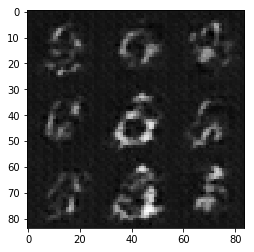

Epoch 1/2... Discriminator Loss: 0.7722... Generator Loss: 2.0474
Epoch 1/2... Discriminator Loss: 0.7216... Generator Loss: 1.6679
Epoch 1/2... Discriminator Loss: 0.7723... Generator Loss: 1.1821
Epoch 1/2... Discriminator Loss: 0.6183... Generator Loss: 1.4735
Epoch 1/2... Discriminator Loss: 1.9661... Generator Loss: 0.2193
Epoch 1/2... Discriminator Loss: 1.2154... Generator Loss: 2.5753
Epoch 1/2... Discriminator Loss: 0.8182... Generator Loss: 2.0669
Epoch 1/2... Discriminator Loss: 0.9447... Generator Loss: 2.4632
Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 3.1278
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 0.3850


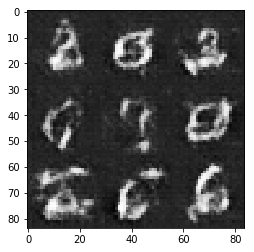

Epoch 1/2... Discriminator Loss: 1.2159... Generator Loss: 2.9223
Epoch 1/2... Discriminator Loss: 0.7196... Generator Loss: 2.1623
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 3.9213
Epoch 1/2... Discriminator Loss: 0.9339... Generator Loss: 0.6928
Epoch 1/2... Discriminator Loss: 1.0552... Generator Loss: 0.6183
Epoch 1/2... Discriminator Loss: 1.1212... Generator Loss: 3.7359
Epoch 1/2... Discriminator Loss: 0.9492... Generator Loss: 2.6353
Epoch 1/2... Discriminator Loss: 0.9775... Generator Loss: 3.5025
Epoch 1/2... Discriminator Loss: 1.1611... Generator Loss: 3.5732
Epoch 1/2... Discriminator Loss: 0.9693... Generator Loss: 3.0690


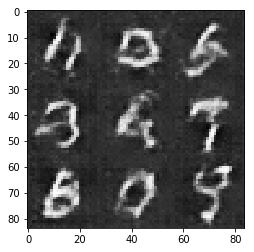

Epoch 2/2... Discriminator Loss: 1.0968... Generator Loss: 0.5550
Epoch 2/2... Discriminator Loss: 0.9959... Generator Loss: 0.6406
Epoch 2/2... Discriminator Loss: 1.0277... Generator Loss: 3.2461
Epoch 2/2... Discriminator Loss: 0.7721... Generator Loss: 0.9826
Epoch 2/2... Discriminator Loss: 0.9960... Generator Loss: 0.6074
Epoch 2/2... Discriminator Loss: 0.8385... Generator Loss: 0.7314
Epoch 2/2... Discriminator Loss: 0.5809... Generator Loss: 1.6264
Epoch 2/2... Discriminator Loss: 1.2914... Generator Loss: 0.4553
Epoch 2/2... Discriminator Loss: 0.8340... Generator Loss: 0.9780
Epoch 2/2... Discriminator Loss: 0.6256... Generator Loss: 1.0333


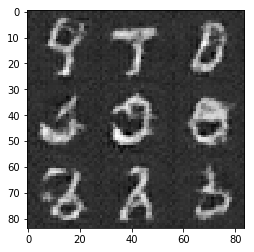

Epoch 2/2... Discriminator Loss: 1.5003... Generator Loss: 0.3371
Epoch 2/2... Discriminator Loss: 1.0373... Generator Loss: 2.2447
Epoch 2/2... Discriminator Loss: 0.6643... Generator Loss: 2.6087
Epoch 2/2... Discriminator Loss: 0.4271... Generator Loss: 1.4918
Epoch 2/2... Discriminator Loss: 0.6742... Generator Loss: 1.9134
Epoch 2/2... Discriminator Loss: 0.5907... Generator Loss: 1.9141
Epoch 2/2... Discriminator Loss: 4.4184... Generator Loss: 5.3612
Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 1.9326
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 2.4325
Epoch 2/2... Discriminator Loss: 1.0529... Generator Loss: 2.4428


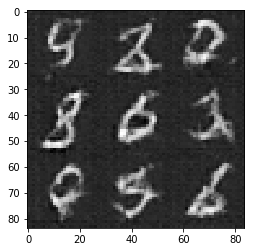

Epoch 2/2... Discriminator Loss: 0.7381... Generator Loss: 2.4211
Epoch 2/2... Discriminator Loss: 0.6496... Generator Loss: 1.1738
Epoch 2/2... Discriminator Loss: 0.7854... Generator Loss: 0.8704
Epoch 2/2... Discriminator Loss: 0.6148... Generator Loss: 1.8058
Epoch 2/2... Discriminator Loss: 0.5919... Generator Loss: 1.8209
Epoch 2/2... Discriminator Loss: 1.2286... Generator Loss: 0.4399
Epoch 2/2... Discriminator Loss: 1.1098... Generator Loss: 2.4585
Epoch 2/2... Discriminator Loss: 0.7178... Generator Loss: 2.2503
Epoch 2/2... Discriminator Loss: 0.7302... Generator Loss: 0.9513
Epoch 2/2... Discriminator Loss: 0.6520... Generator Loss: 2.5562


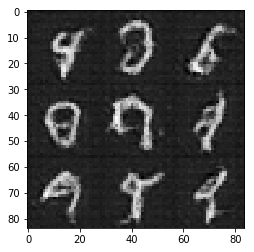

Epoch 2/2... Discriminator Loss: 0.7211... Generator Loss: 1.4260
Epoch 2/2... Discriminator Loss: 0.9383... Generator Loss: 0.6384
Epoch 2/2... Discriminator Loss: 0.7589... Generator Loss: 1.0110
Epoch 2/2... Discriminator Loss: 0.8788... Generator Loss: 0.9277
Epoch 2/2... Discriminator Loss: 1.2396... Generator Loss: 2.4043
Epoch 2/2... Discriminator Loss: 1.1258... Generator Loss: 0.5239
Epoch 2/2... Discriminator Loss: 0.9766... Generator Loss: 0.5833
Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 0.4688
Epoch 2/2... Discriminator Loss: 0.8846... Generator Loss: 1.0329
Epoch 2/2... Discriminator Loss: 1.1648... Generator Loss: 0.5556


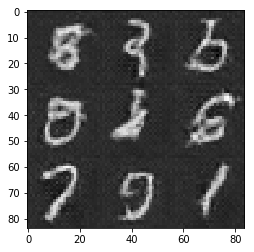

IndexError: list index out of range

In [14]:
batch_size = 150
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1603... Generator Loss: 2.6538
Epoch 1/1... Discriminator Loss: 0.0446... Generator Loss: 3.9384
Epoch 1/1... Discriminator Loss: 0.0257... Generator Loss: 4.3637
Epoch 1/1... Discriminator Loss: 0.0205... Generator Loss: 4.7665
Epoch 1/1... Discriminator Loss: 0.0123... Generator Loss: 4.8637
Epoch 1/1... Discriminator Loss: 0.0267... Generator Loss: 10.8958
Epoch 1/1... Discriminator Loss: 0.0223... Generator Loss: 4.4341
Epoch 1/1... Discriminator Loss: 0.0191... Generator Loss: 4.6746
Epoch 1/1... Discriminator Loss: 0.0228... Generator Loss: 4.3752
Epoch 1/1... Discriminator Loss: 0.0096... Generator Loss: 5.5023


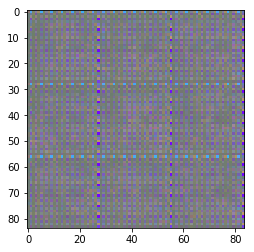

Epoch 1/1... Discriminator Loss: 0.0063... Generator Loss: 6.3965
Epoch 1/1... Discriminator Loss: 0.0042... Generator Loss: 6.2950
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 6.4248
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 6.9456
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 6.8206
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 7.0932
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 6.8858
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.3477
Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 6.9710
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.5257


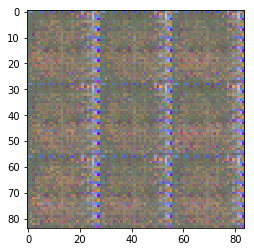

Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 7.0476
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 7.8671
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.3401
Epoch 1/1... Discriminator Loss: 0.0017... Generator Loss: 6.9763
Epoch 1/1... Discriminator Loss: 0.0016... Generator Loss: 6.6673
Epoch 1/1... Discriminator Loss: 0.1857... Generator Loss: 37.9191
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 6.6465
Epoch 1/1... Discriminator Loss: 0.0040... Generator Loss: 6.0772
Epoch 1/1... Discriminator Loss: 0.0047... Generator Loss: 6.4302
Epoch 1/1... Discriminator Loss: 0.0056... Generator Loss: 6.7458


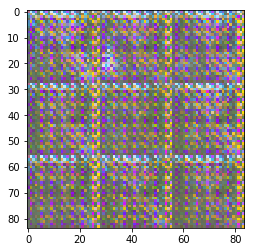

Epoch 1/1... Discriminator Loss: 0.4227... Generator Loss: 1.5156
Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 20.1499
Epoch 1/1... Discriminator Loss: 0.1136... Generator Loss: 4.1603
Epoch 1/1... Discriminator Loss: 2.8638... Generator Loss: 0.4013
Epoch 1/1... Discriminator Loss: 0.0691... Generator Loss: 5.3351
Epoch 1/1... Discriminator Loss: 0.1663... Generator Loss: 3.9587
Epoch 1/1... Discriminator Loss: 2.6273... Generator Loss: 0.2068
Epoch 1/1... Discriminator Loss: 0.4838... Generator Loss: 1.5272
Epoch 1/1... Discriminator Loss: 0.3763... Generator Loss: 4.5291
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.4932


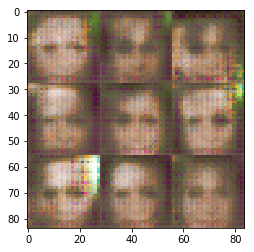

Epoch 1/1... Discriminator Loss: 0.1897... Generator Loss: 3.8431
Epoch 1/1... Discriminator Loss: 0.2990... Generator Loss: 3.7896
Epoch 1/1... Discriminator Loss: 1.8912... Generator Loss: 0.3435
Epoch 1/1... Discriminator Loss: 0.3093... Generator Loss: 2.0327
Epoch 1/1... Discriminator Loss: 0.2810... Generator Loss: 2.2133
Epoch 1/1... Discriminator Loss: 0.5175... Generator Loss: 3.4754
Epoch 1/1... Discriminator Loss: 0.2258... Generator Loss: 2.9751
Epoch 1/1... Discriminator Loss: 0.4604... Generator Loss: 4.4504
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 3.8034
Epoch 1/1... Discriminator Loss: 0.4233... Generator Loss: 2.4197


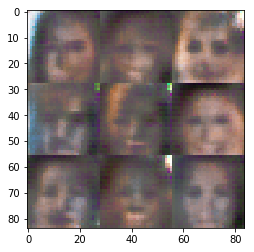

Epoch 1/1... Discriminator Loss: 0.4907... Generator Loss: 2.7437
Epoch 1/1... Discriminator Loss: 0.3489... Generator Loss: 2.8388
Epoch 1/1... Discriminator Loss: 1.7105... Generator Loss: 4.2008
Epoch 1/1... Discriminator Loss: 0.3043... Generator Loss: 3.4063
Epoch 1/1... Discriminator Loss: 0.6551... Generator Loss: 2.2821
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 1.7367
Epoch 1/1... Discriminator Loss: 0.5506... Generator Loss: 1.3776
Epoch 1/1... Discriminator Loss: 0.4766... Generator Loss: 1.9177
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 4.7116
Epoch 1/1... Discriminator Loss: 0.3666... Generator Loss: 2.4746


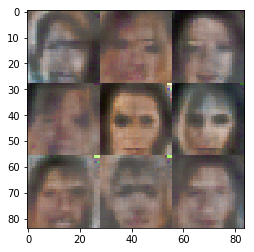

Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 2.3747
Epoch 1/1... Discriminator Loss: 0.4456... Generator Loss: 2.0922
Epoch 1/1... Discriminator Loss: 0.4772... Generator Loss: 2.4303
Epoch 1/1... Discriminator Loss: 0.6730... Generator Loss: 2.1706
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 3.6901
Epoch 1/1... Discriminator Loss: 0.6778... Generator Loss: 1.2912
Epoch 1/1... Discriminator Loss: 0.6213... Generator Loss: 2.5240
Epoch 1/1... Discriminator Loss: 0.5245... Generator Loss: 2.0639
Epoch 1/1... Discriminator Loss: 0.5209... Generator Loss: 1.7460
Epoch 1/1... Discriminator Loss: 0.4689... Generator Loss: 1.8089


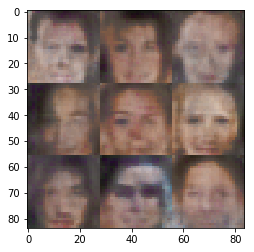

Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 2.0882
Epoch 1/1... Discriminator Loss: 0.6322... Generator Loss: 2.5361
Epoch 1/1... Discriminator Loss: 0.4831... Generator Loss: 1.8911
Epoch 1/1... Discriminator Loss: 0.5333... Generator Loss: 2.2450
Epoch 1/1... Discriminator Loss: 0.4947... Generator Loss: 1.8020
Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 1.6057
Epoch 1/1... Discriminator Loss: 0.4207... Generator Loss: 1.7007
Epoch 1/1... Discriminator Loss: 0.8596... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 0.8455... Generator Loss: 1.3871
Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 2.0168


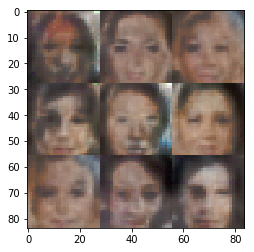

Epoch 1/1... Discriminator Loss: 0.6266... Generator Loss: 2.4858
Epoch 1/1... Discriminator Loss: 0.7374... Generator Loss: 1.2474
Epoch 1/1... Discriminator Loss: 0.6062... Generator Loss: 1.6287
Epoch 1/1... Discriminator Loss: 0.4664... Generator Loss: 1.7922
Epoch 1/1... Discriminator Loss: 0.5478... Generator Loss: 1.8905
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 2.6328
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 1.2973
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 0.8062


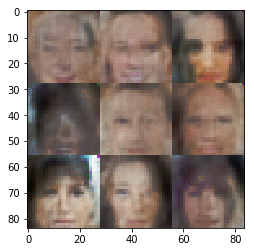

Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 1.7606
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.5058
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 1.4569
Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 1.2069
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 2.1165
Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.4878
Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 1.5790
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.2018
Epoch 1/1... Discriminator Loss: 0.6081... Generator Loss: 1.8851
Epoch 1/1... Discriminator Loss: 0.7274... Generator Loss: 1.1504


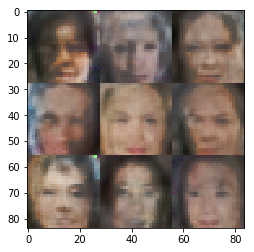

Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 0.6673... Generator Loss: 2.0194
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 3.4763
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.6135
Epoch 1/1... Discriminator Loss: 0.7328... Generator Loss: 1.4771
Epoch 1/1... Discriminator Loss: 0.2990... Generator Loss: 2.8173
Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 1.1679
Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 1.4027
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 1.6912
Epoch 1/1... Discriminator Loss: 0.7004... Generator Loss: 1.7659


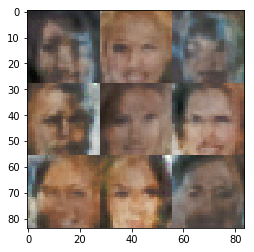

Epoch 1/1... Discriminator Loss: 0.5965... Generator Loss: 1.6674
Epoch 1/1... Discriminator Loss: 0.1852... Generator Loss: 3.8914
Epoch 1/1... Discriminator Loss: 0.5974... Generator Loss: 1.7532
Epoch 1/1... Discriminator Loss: 1.5962... Generator Loss: 0.3375
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 1.5826
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 1.2866
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 0.5671... Generator Loss: 1.6813
Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 1.1904


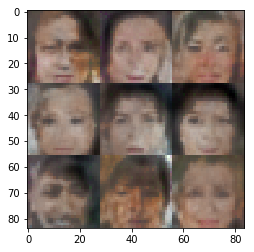

Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 1.2610
Epoch 1/1... Discriminator Loss: 0.5192... Generator Loss: 1.8774
Epoch 1/1... Discriminator Loss: 0.8985... Generator Loss: 1.1793
Epoch 1/1... Discriminator Loss: 1.5854... Generator Loss: 0.3138
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.0500
Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 1.1716
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 0.8287


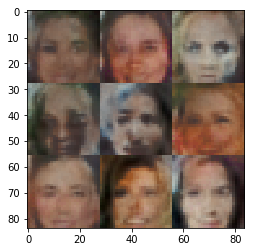

Epoch 1/1... Discriminator Loss: 0.6693... Generator Loss: 1.2198
Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 3.5327... Generator Loss: 0.1104
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 1.0664
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.1745
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.2273
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 2.5054... Generator Loss: 2.6329


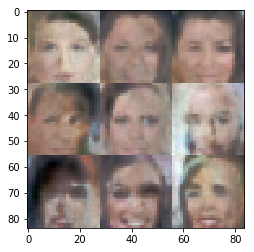

Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 1.4601
Epoch 1/1... Discriminator Loss: 0.6788... Generator Loss: 1.6305
Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 1.0642
Epoch 1/1... Discriminator Loss: 0.7842... Generator Loss: 1.4870
Epoch 1/1... Discriminator Loss: 0.6637... Generator Loss: 1.2937
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 1.4941
Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 1.4924
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 1.5826


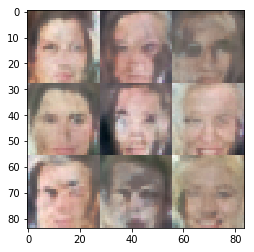

Epoch 1/1... Discriminator Loss: 0.8510... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 0.8006... Generator Loss: 1.0739
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.4381
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 1.4772
Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 0.7943... Generator Loss: 1.1300


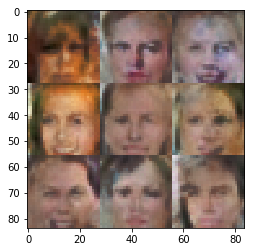

Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.4894
Epoch 1/1... Discriminator Loss: 2.4667... Generator Loss: 2.5208
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 1.3576
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 1.1040
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 1.4109


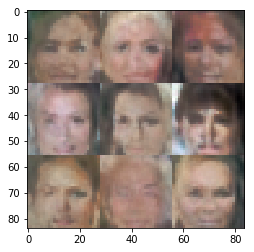

Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 0.9737
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 1.5121
Epoch 1/1... Discriminator Loss: 0.7864... Generator Loss: 1.6457
Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 1.4152
Epoch 1/1... Discriminator Loss: 3.0229... Generator Loss: 3.2080
Epoch 1/1... Discriminator Loss: 1.9850... Generator Loss: 1.1084
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 0.9617


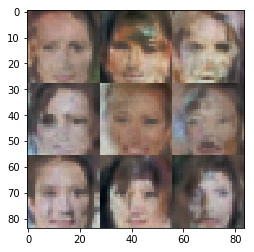

Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.0389
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 1.8956
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 1.7117
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 1.0568
Epoch 1/1... Discriminator Loss: 0.6681... Generator Loss: 1.5764


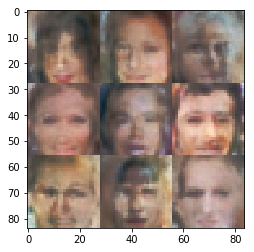

Epoch 1/1... Discriminator Loss: 0.9358... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 1.4781
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 1.1176
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 1.1921


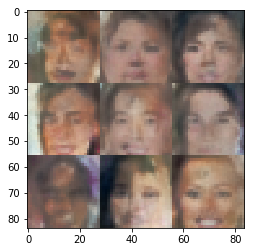

Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 1.0046


IndexError: list index out of range

In [16]:
batch_size = 100
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.